# AFM analisis

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True                    # render text via LaTeX
})

In [43]:
file_path_topography = r"H:\Seafile\Master\Data\AFM\2026-01-16_cTLM_01\relevant\20251216_Strucktur_7-1_TLM_15um_200mV_Topography.txt"
# file_path_current = r"H:\2025-12-11_Valencia\Valencia-p_Struktur-5-3_current.txt"
# file_path_retracecurrent = r"H:\Seafile\Master\Data\AFM\2026-01-16_cTLM_01\relevant\20251216_Strucktur_7-1_TLM_15um_200mV_Retrace_Current.txt"
file_path_retracecurrent = r"H:\Seafile\Master\Data\AFM\2026-01-16_cTLM_01\relevant\20251216_Strucktur_7-1_TLM_15um_200mV_Retrace_Current_flat.txt"

topography_array = np.loadtxt(file_path_topography, delimiter=None)
# current_array = np.loadtxt(file_path_current, delimiter=None)
RetraceCurrent_array = np.loadtxt(file_path_retracecurrent, delimiter=None)

In [20]:
physical_width = 40   # x in µm
physical_height = 40  # y in µm

ny, nx = topography_array.shape

x_1d = np.linspace(0, physical_width, nx)
y_1d = np.linspace(0, physical_height, ny)

X, Y = np.meshgrid(x_1d, y_1d)

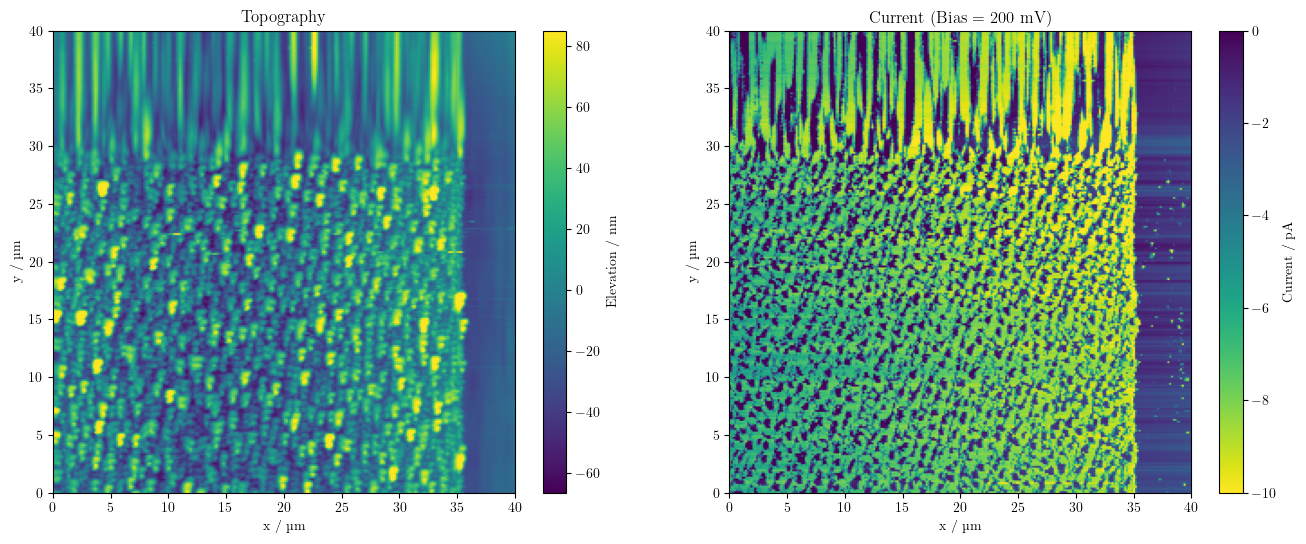

In [53]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
# remove top 1% from colorbar for better contrast
vmax = np.percentile(topography_array, 99)   # ignore top 1%
# vmin = np.percentile(topography_array, 1)    # optional

topography = ax1.imshow(topography_array, cmap='viridis', extent=[0, physical_width, 0, physical_height],vmax=vmax)
cbar1 = plt.colorbar(topography, ax=ax1, fraction=0.045, pad=0.05)   # fraction=0.05, pad=0.05
cbar1.set_label('Elevation / nm')
ax1.set_title("Topography")
ax1.set_xlabel("x / µm")
ax1.set_ylabel("y / µm")


ax2 = fig.add_subplot(1,2,2)
current = ax2.imshow(RetraceCurrent_array, cmap='viridis_r', extent=[0, physical_width, 0, physical_height], vmax=0, vmin=-10)  # plasma inferno Spectral viridis magma
cbar2 = plt.colorbar(current, ax=ax2, fraction=0.045, pad=0.05)
cbar2.set_label('Current / pA')
ax2.set_title("Current (Bias = 200 mV)")
ax2.set_xlabel("x / µm")
ax2.set_ylabel("y / µm")
# plt.show()
plt.savefig('../Images/cTLM_Ni_AFM.pdf', dpi=1000)

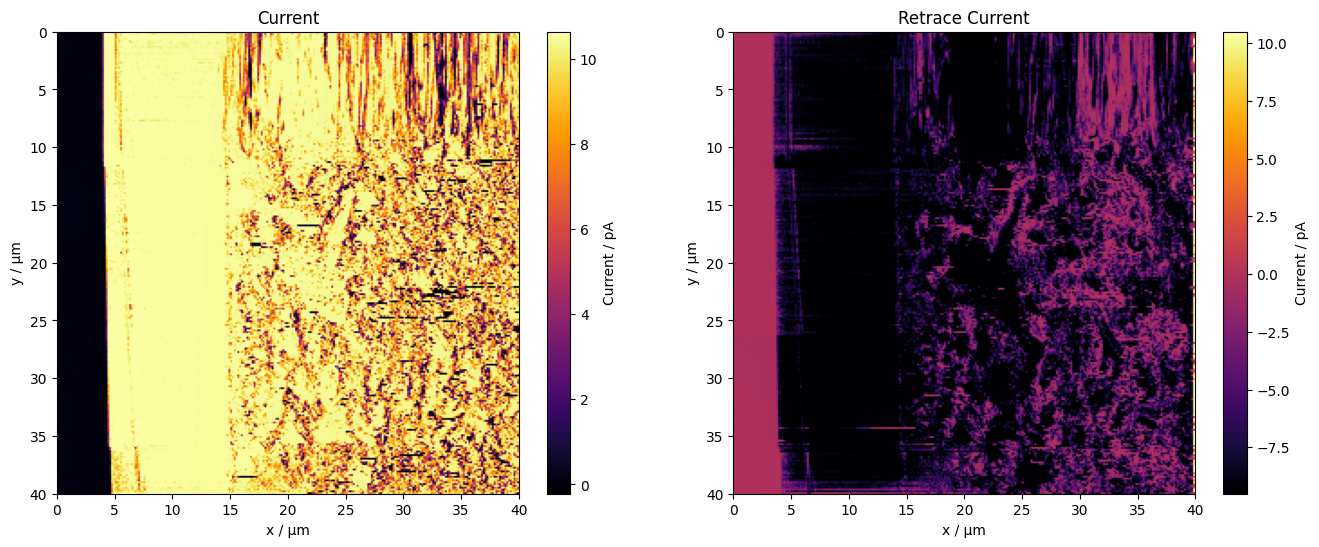

In [17]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
current = ax1.imshow(current_array, cmap='inferno', extent=[0, physical_width, physical_height, 0])
cbar1 = plt.colorbar(current, ax=ax1, fraction=0.045, pad=0.05)   # fraction=0.05, pad=0.05
cbar1.set_label('Current / pA')
ax1.set_title("Current")
ax1.set_xlabel("x / µm")
ax1.set_ylabel("y / µm")

ax2 = fig.add_subplot(1,2,2)
RetraceCurrent = ax2.imshow(RetraceCurrent_array, cmap='inferno', extent=[0, physical_width, physical_height, 0])  # plasma inferno
cbar2 = plt.colorbar(RetraceCurrent, ax=ax2, fraction=0.045, pad=0.05)
cbar2.set_label('Current / pA')
ax2.set_title("Retrace Current")
ax2.set_xlabel("x / µm")
ax2.set_ylabel("y / µm")
plt.show()

### combine topography with current colormap

In [5]:
def process_topograhy_data(topography):
    # Destriping (Line Flattening)
    topo_flattened = topography - np.median(topography, axis=1, keepdims=True)
    
    # Smooth the Topography by applaying a filter
    topo_smooth = gaussian_filter(topo_flattened, sigma=1)

    return topo_smooth

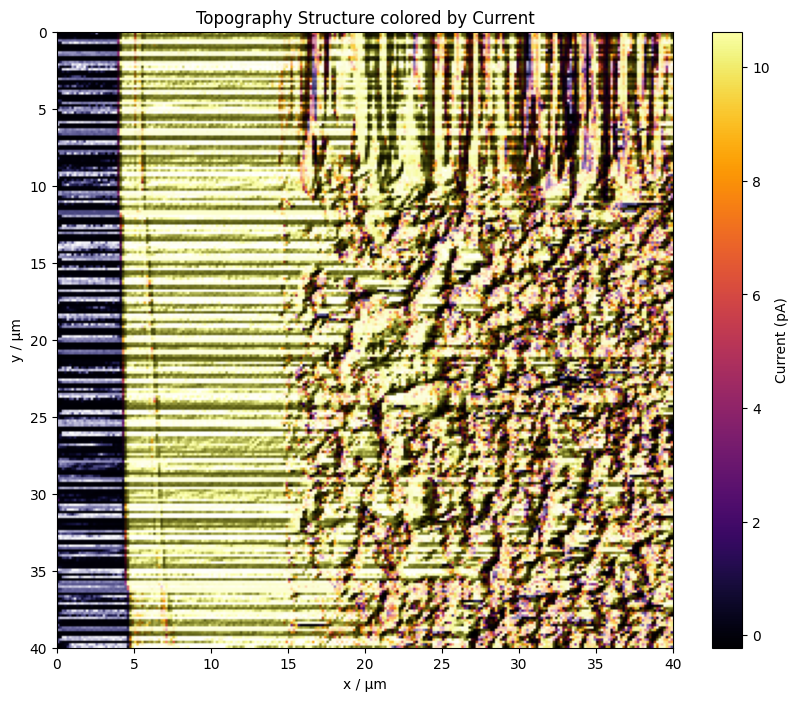

In [6]:
from matplotlib.colors import LightSource, Normalize
# convert current array to colormap
# Normalize the current data to 0.0 - 1.0
# vmin/vmax clip the outliers so the weak currents are still visible
norm = Normalize(vmin=current_array.min(), vmax=np.percentile(current_array, 99)) # Using 99th percentile clips extreme hot spots
cmap = plt.cm.inferno 
current_rgb = cmap(norm(current_array))

# LightSource creates the 3D shadow effect
ls = LightSource(azdeg=315, altdeg=45)

final_image = ls.shade_rgb(current_rgb, elevation=topography_array)    #  vert_exag=0.5, blend_mode='overlay'

# # hide pixels where topography is between -5 and 5 => declutter topography
# hidden_mask = (topography_array > -20) & (topography_array < 20)
# # final_image is an array of shape (Height, Width, 4) -> (R, G, B, Alpha)
# # 4th channel (index 3) set it to 0 (transparent)
# final_image[hidden_mask, 3] = 0.0

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(final_image, origin='upper', extent=[0, physical_width, physical_height, 0])

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Current (pA)')

ax.set_title("Topography Structure colored by Current")
ax.set_xlabel("x / µm")
ax.set_ylabel("y / µm")

plt.show()

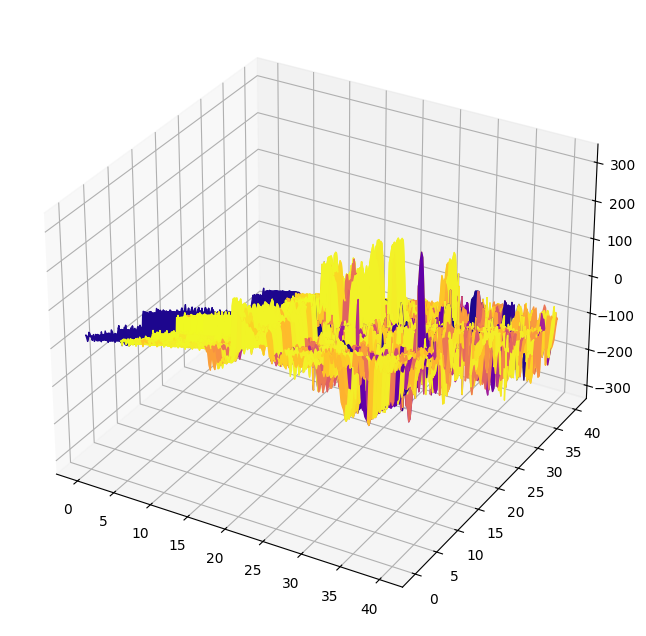

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))

# Create the facecolors based on the Current array
norm = plt.Normalize(current_array.min(), current_array.max())
colors = plt.cm.plasma(norm(current_array))

# Plot surface: Z=Topography, Facecolors=Current
surf = ax.plot_surface(X, Y, topography_array, facecolors=colors, shade=False)

plt.show()

### use current and reverse current to identify ohmic beahaviour
-> check if current is roughly the same absolute value using the negative and positiv bias values

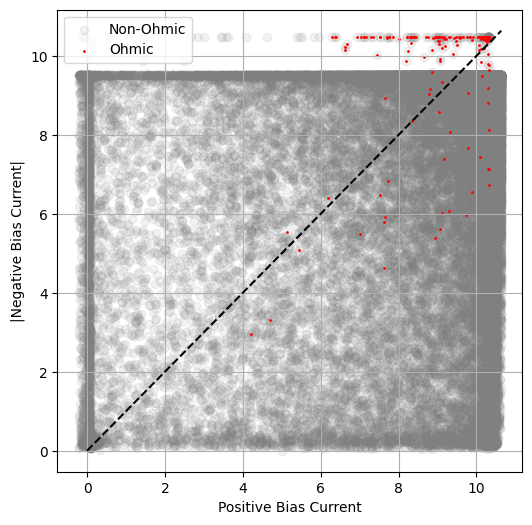

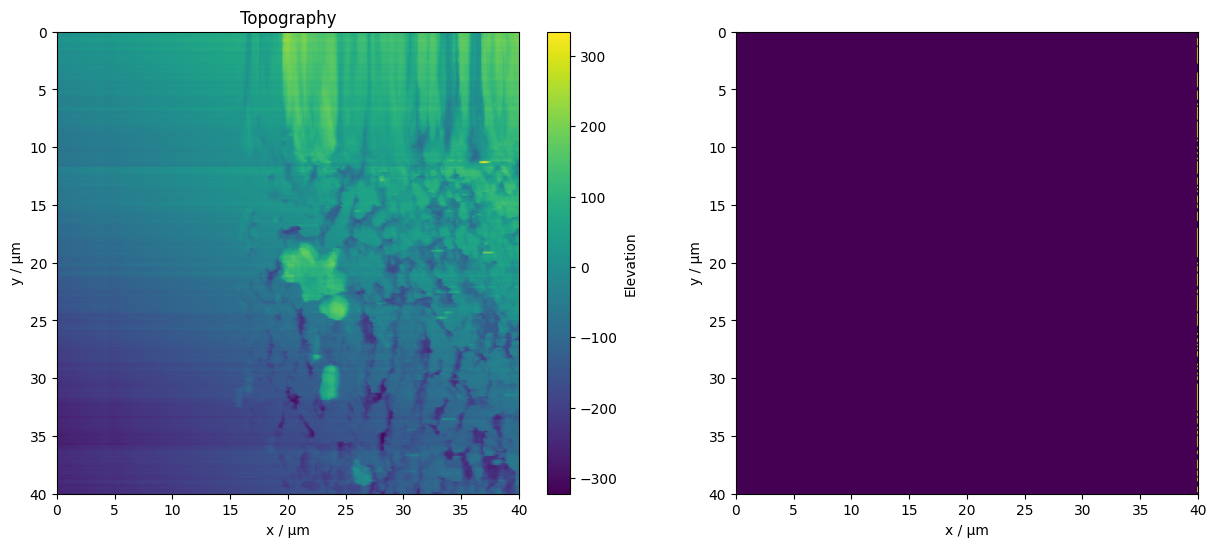

In [19]:
# current_delta = current_array - abs(RetraceCurrent_array)
# print(current_delta)

pos_current = current_array
neg_current_abs = np.abs(RetraceCurrent_array)

# NOISE_FLOOR: If current is below this (e.g., 2 pA), its considered insulating/noise
# TOLERANCE: The allowed relative difference (0.2 = 20% difference allowed)
NOISE_FLOOR = 1.0 
TOLERANCE = 0.5

avg_current = (current_array + RetraceCurrent_array) / 2.0

rel_diff = np.abs(pos_current - neg_current_abs) / (avg_current + 1e-12)    # add tiniy value to avoid dividing by zero

is_conducting = avg_current > NOISE_FLOOR
is_symmetric = rel_diff < TOLERANCE

# combine conditions to create ahmic mask
ohmic_mask = is_conducting & is_symmetric


# Test plot to show ohmic behaviour is actually recognized
plt.figure(figsize=(6,6))
# Plot ALL points in gray
plt.scatter(pos_current.flatten(), neg_current_abs.flatten(), c='gray', alpha=0.1, label='Non-Ohmic')
# Plot OHMIC points in red (using your new mask)
plt.scatter(pos_current[ohmic_mask], neg_current_abs[ohmic_mask], c='red', s=1, label='Ohmic')
# Draw the perfect 1:1 line
max_val = max(pos_current.max(), neg_current_abs.max())
plt.plot([0, max_val], [0, max_val], 'k--')
plt.xlabel("Positive Bias Current")
plt.ylabel("|Negative Bias Current|")
plt.legend()
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
topography = ax1.imshow(topography_array, cmap='viridis', extent=[0, physical_width, physical_height, 0])
cbar1 = plt.colorbar(topography, ax=ax1, fraction=0.045, pad=0.05)   # fraction=0.05, pad=0.05
cbar1.set_label('Elevation')
ax1.set_title("Topography")
ax1.set_xlabel("x / µm")
ax1.set_ylabel("y / µm")

ax2 = fig.add_subplot(1,2,2)
im = ax2.imshow(ohmic_mask, origin='upper', extent=[0, physical_width, physical_height, 0])
ax2.set_xlabel("x / µm")
ax2.set_ylabel("y / µm")
plt.show()